# Qubit Optimization for 3-qubit Ising model 

We will be comparing PennyLane *gradient descent optimizer* with that of `Tensorflow` and `Pytorch` optimizer for this quantum system. For details on these interfaces, see [pennylane interfaces](https://pennylane.readthedocs.io/en/latest/code/interfaces.html).

Ising model is an example of a system whose optimization landscape is non-convex and hence using gradient descent is not the best solution since the optimization can get stuck in local minimas. Quantum annealing (for example on D-wave system) can be used instead. 

The energy for this system is given by:
$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

where each spin can be in +1 or -1 state and $J_{ij}$ are nearest neighbour coupling strengths.

For simplicity, we will assume that spin 1 is always in up state (+1 eigenstate of Pauli-Z operator)

> <font color=brown>**NOTE:** To follow along with this tutorial on your own computer, you will require the the following dependencies:
    
> - [PyTorch](https://pytorch.org/get-started/locally/) in order to access the PyTorch QNode interface. Follow the link for instructions on the best way to install PyTorch for your system.

> - [TensorFlow](https://www.tensorflow.org/) in order to access the TensorFlow QNode interface. Follow the link for instructions on the best way to install Tensorflow for your system. 
</font>

## PennyLane Optimizer

In [1]:
# import PennyLane library
import pennylane as qml
from pennylane import numpy as np

In [2]:
# create our three devices. 
dev1 = qml.device('default.qubit', wires=3)
dev2 = qml.device('default.qubit', wires=3)
dev3 = qml.device('default.qubit', wires=3)

In [3]:
# We can use the GENERAL PennyLane Rot(phi,theta,omega,wires) operation
@qml.qnode(dev1)
def circuit1(p1, p2):
    qml.Rot(p1[0],p1[1],p1[2], wires =1)
    qml.Rot(p2[0],p2[1],p2[2], wires =2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

Our cost function is the energy of the spin configuration which we will optimize using gradient descent.

Let the coupling matrix be J = [1,-1]

In [4]:
def cost1(var):
    spins = circuit1(var[0],var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

Lets test these functions for [1,-1,-1] spin configuration. 

Total energy for this Ising model should be

$H = -1(J1.s1.s2 + J2.s2.s3) = -1 (1*1*-1 + -1*-1*-1) = 2 $


In [5]:
# You can easily guess the angles if you look at the Rot(phi,theta,omega)
t1 = np.array([0, np.pi, 0])    #spin 2 in -1 state
t2 = np.array([0,np.pi ,0])     #spin 3 in -1 state
print(cost1([t1,t2]))

2.0


Now we optimize using PennyLane NumPy gradient descent optimizer


In [6]:
# initialize the parameters to some random values
pl1 = np.pi*(np.random.ranf(3))
pl2 = np.pi*(np.random.ranf(3))
var_init = np.array([pl1,pl2])
cost_init = cost1(var_init)
print(cost_init)

-0.818302157836952


The minimun energy should be -2 for [1,1,-1] spin configuration which corresponds to the angles of [0,0,0] and [0,pi,0] for the spin 2 and spin 3 respectively. 

In [7]:
gd = qml.GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost1, var)
    if (it + 1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost1(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost1(var), var))

Energy after step     5: -1.9713433 | Angles: [[2.11397782e-01 2.61730009e-03 1.90231741e+00]
 [1.83438711e+00 2.90164357e+00 3.13683905e+00]]
Energy after step    10: -1.9998224 | Angles: [[2.11397782e-01 9.14342134e-07 1.90231741e+00]
 [1.83438711e+00 3.12274773e+00 3.13683905e+00]]
Energy after step    15: -1.9999989 | Angles: [[2.11397782e-01 2.92751109e-10 1.90231741e+00]
 [1.83438711e+00 3.14012718e+00 3.13683905e+00]]
Energy after step    20: -2.0000000 | Angles: [[2.11397782e-01 9.37242757e-14 1.90231741e+00]
 [1.83438711e+00 3.14147870e+00 3.13683905e+00]]
Energy after step    25: -2.0000000 | Angles: [[ 2.11397782e-01 -7.51740210e-19  1.90231741e+00]
 [ 1.83438711e+00  3.14158379e+00  3.13683905e+00]]
Energy after step    30: -2.0000000 | Angles: [[ 2.11397782e-01 -7.51740210e-19  1.90231741e+00]
 [ 1.83438711e+00  3.14159196e+00  3.13683905e+00]]
Energy after step    35: -2.0000000 | Angles: [[ 2.11397782e-01 -7.51740210e-19  1.90231741e+00]
 [ 1.83438711e+00  3.14159260e+00

## Tenserflow Optimizer

In [8]:
# activate and check if the eager tenserflow execution is working
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()
print(tf.executing_eagerly())

True


In [9]:
# the interface is given as an arguemnt when constructing the QNode
@qml.qnode(dev2, interface='tfe')
def circuit2(p1, p2):
        qml.Rot(p1[0],p1[1],p1[2], wires =1)
        qml.Rot(p2[0],p2[1],p2[2], wires =2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [10]:
def cost2(var):
    spins = circuit2(var[0],var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [11]:
# lets test the functions again for our known spin configuration [1,-1,-1]
t1 = tfe.Variable([0, np.pi, 0], dtype=tf.float64)
t2 = tfe.Variable([0, np.pi, 0], dtype=tf.float64)
print(cost2([t1,t2]))

Instructions for updating:
Colocations handled automatically by placer.


tf.Tensor(2.0, shape=(), dtype=float64)


In [12]:
#initialize the parameters to some random values
tf1 = tfe.Variable(tf.random_uniform([3],0,np.pi, dtype = tf.float64))
tf2 = tfe.Variable(tf.random_uniform([3],0,np.pi, dtype = tf.float64))
var_init = [tf1,tf2]
cost_init = cost2(var_init)
print(cost_init)

tf.Tensor(0.9345447201991628, shape=(), dtype=float64)


In [13]:
#optimize using tensorflow optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost2([tf1,tf2])
        grads = tape.gradient(loss, [tf1, tf2])

    opt.apply_gradients(zip(grads, [tf1, tf2]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf1,tf2])
            cost_tf.append (cost2([tf1,tf2]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost2([tf1,tf2]), [tf1.numpy(),tf2.numpy()]))

Energy after step     5:  0.3586118 | Angles: [array([2.84415863, 1.94387809, 2.54041458]), array([2.90647332, 1.55467679, 2.32674317])]
Energy after step    10: -0.0699088 | Angles: [array([2.84415863, 1.49217174, 2.54041458]), array([2.90647332, 1.46063785, 2.32674317])]
Energy after step    15: -0.5053414 | Angles: [array([2.84415863, 1.04968241, 2.54041458]), array([2.90647332, 1.58585145, 2.32674317])]
Energy after step    20: -1.0740985 | Angles: [array([2.84415863, 0.62320589, 2.54041458]), array([2.90647332, 1.89944316, 2.32674317])]
Energy after step    25: -1.5862403 | Angles: [array([2.84415863, 0.29189344, 2.54041458]), array([2.90647332, 2.2867015 , 2.32674317])]
Energy after step    30: -1.8483960 | Angles: [array([2.84415863, 0.11247044, 2.54041458]), array([2.90647332, 2.60635745, 2.32674317])]
Energy after step    35: -1.9469712 | Angles: [array([2.84415863, 0.0392157 , 2.54041458]), array([2.90647332, 2.81916584, 2.32674317])]
Energy after step    40: -1.9815122 | Ang

## PyTorch Optimizer

In [14]:
import torch
from torch.autograd import Variable

In [15]:
# the interface is given as an arguemnt when constructing the QNode
@qml.qnode(dev3, interface='torch')
def circuit3(p1, p2):
    qml.Rot(p1[0],p1[1],p1[2], wires =1)
    qml.Rot(p2[0],p2[1],p2[2], wires =2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [16]:
def cost3(var1,var2):
    spins = circuit3(var1,var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [17]:
#lets test the functions again for our known spin configuration [1,-1,-1]
t1=torch.tensor([0, np.pi, 0])
t2=torch.tensor([0,np.pi ,0])
print(cost3(t1,t2))

tensor(2.0000, dtype=torch.float64)


In [18]:
pt1 = Variable((np.pi*torch.rand(3,dtype=torch.float64)), requires_grad=True)
pt2 = Variable((np.pi*torch.rand(3,dtype=torch.float64)), requires_grad=True)
var_init = [pt1,pt2]
cost_init = cost3(pt1,pt2)
print(cost_init)

tensor(-1.2960, dtype=torch.float64, grad_fn=<SubBackward0>)


In [19]:
#optimizing using PyTorch optimizer 
opt = torch.optim.Adam(var_init, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost3(pt1, pt2)
    loss.backward()
    return loss

var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt1, pt2 = opt.param_groups[0]['params']
        costn = cost3(pt1, pt2)
        var_pt.append([pt1,pt2])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt1.detach().numpy(), pt2.detach().numpy()]))

Energy after step     5: -1.7547951 | Angles: [array([ 2.33328647, -0.11022775,  0.33939164]), array([1.29015008, 2.44262964, 0.35468735])]
Energy after step    10: -1.9683916 | Angles: [array([ 2.33328647, -0.06696248,  0.33939164]), array([1.29015008, 2.90787876, 0.35468735])]
Energy after step    15: -1.9852637 | Angles: [array([2.33328647, 0.08629981, 0.33939164]), array([1.29015008, 3.26266667, 0.35468735])]
Energy after step    20: -1.9606606 | Angles: [array([2.33328647, 0.01613939, 0.33939164]), array([1.29015008, 3.42209677, 0.35468735])]
Energy after step    25: -1.9658844 | Angles: [array([ 2.33328647, -0.05584007,  0.33939164]), array([1.29015008, 3.39142729, 0.35468735])]
Energy after step    30: -1.9933538 | Angles: [array([2.33328648, 0.00721122, 0.33939164]), array([1.29015008, 3.25649816, 0.35468735])]
Energy after step    35: -1.9987513 | Angles: [array([2.33328648, 0.03053292, 0.33939164]), array([1.29015008, 3.11642467, 0.35468735])]
Energy after step    40: -1.9947

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)

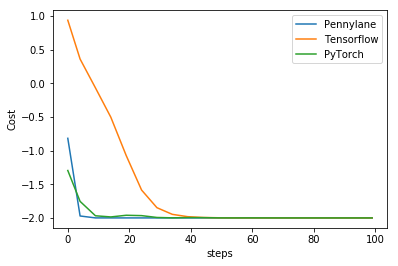

In [22]:
plt.plot(x,cost_gd,label='Pennylane')
plt.plot(x,cost_tf,label='Tensorflow')
plt.plot(x,cost_pt,label='PyTorch')
plt.xlabel("steps")
plt.ylabel("Cost")
plt.legend()
plt.show()

In some runs, you will see the optimization getting stuck in a local minima of energy (usually zero energy). Do not forget to restart the kernel before rerunning the file! 